In [181]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from operator import add
import random
import copy

In [2]:
grid_size = (5,5)
action_space = ("left","right","up","down")


In [114]:
class CityTravels(gym.Env):
    def __init__(self,env_type,max_timesteps):
        self.env_type = env_type
        self.observation_space = spaces.Discrete(25)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = max_timesteps
#         if env_type == "deterministic":
#             self.max_timesteps = 50
#         elif env_type == "stochastic":
#             self.max_timesteps = 25
    
            
    def reset(self):
        self.timestep = 0
        self.penalties = 0
        self.rewards = 0
        
        self.agent_pos = np.array([0, 0])
        self.coin_positions = np.array([[4,4],[1,4],[2,3]])
        self.thief_positions = np.array([[2,2],[1,1],[3,3]])
        self.food_positions = np.array([[0,4],[4,0]])
        self.goal_pos = np.array([3, 4])
        
        self.state = np.zeros(grid_size)
        self.state[tuple(self.agent_pos)] = 1  # Setting as rewards for each state
        self.state[tuple(self.goal_pos)] = 50
        
        for pos in self.coin_positions:
            self.state[tuple(pos)] = 10
        for pos in self.thief_positions:
            self.state[tuple(pos)] = -20
        for pos in self.food_positions:
            self.state[tuple(pos)] = 5
            
        observation = self.state.flatten()
        
        self.total_reward = 0
        self.done = False

        
        return
    
    def step(self, action):
        prev_pos = self.agent_pos.copy()
#         print("prev_pos : {}".format(prev_pos))
        def execute_action(step_execution_probability=1):
            if not step_execution_probability == 1 and random.random() > step_execution_probability:
#                 print("Not performing anything : stochastic")
                return
            
            if action == 0:
                self.agent_pos[0] -= 1
            if action == 1:
                self.agent_pos[0] += 1
            if action == 2:
                self.agent_pos[1] += 1
            if action == 3:
                self.agent_pos[1] -= 1
                
        self.state = np.random.choice(self.observation_space.n)       
        step_execution_probability = 1
        
        if self.env_type == "stochastic":
            step_execution_probability = 0.9
        execute_action(step_execution_probability)
        
        
        self.agent_pos = np.clip(self.agent_pos, 0, 4)
#         print(self.agent_pos)    
        self.state = np.zeros(grid_size)

        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 50 
        for pos in self.coin_positions:
            self.state[tuple(pos)] = 10
        for pos in self.thief_positions:
            self.state[tuple(pos)] = -20
        for pos in self.food_positions:
            self.state[tuple(pos)] = 5
        observation = self.state.flatten()  
        
        reward = -0.1
#         print(self.agent_pos,prev_pos)
        if np.all(self.agent_pos == prev_pos):
#             print("No ACTION PERFORMED")
            reward = -1  
#             self.penalties += 1
        if (self.agent_pos == self.goal_pos).all():
            reward = 50
            self.done = True
            self.rewards += 1
        if (np.any(np.all(self.agent_pos == self.coin_positions, axis=1))):
            reward = 10
            for index in range(len(self.coin_positions)):
                if (self.coin_positions[index]==self.agent_pos).all():
                    self.coin_positions = np.delete(self.coin_positions, index, axis=0)
                    self.rewards += 1
                    break            
        if (np.any(np.all(self.agent_pos == self.food_positions, axis=1))):
            reward = 5
            for index in range(len(self.food_positions)):
                if (self.food_positions[index]==self.agent_pos).all():
                    self.food_positions = np.delete(self.food_positions, index, axis=0)
                    self.rewards += 1
                    break  
        if (np.any(np.all(self.agent_pos == self.thief_positions, axis=1))):
            reward = -20
            for index in range(len(self.thief_positions)):
                if (self.thief_positions[index]==self.agent_pos).all():
                    self.thief_positions = np.delete(self.thief_positions, index, axis=0)
                    self.penalties += 1
                    break  
            
        self.total_reward += reward
        
        self.timestep += 1
        if not self.done:
            self.done = True if self.timestep >= self.max_timesteps else False
        
        info = {}
        
        return observation, reward, self.done, info
    
    def render(self,reward=0):
        fig,ax = plt.subplots(figsize=(15,15))
        ax.set_xlim(0,5)
        ax.set_ylim(0,5)
        plt.grid()
        agent_added = False
        home_added = False
        
        if not (reward == 0 or reward == -0.1 or reward == -1):
            if reward == 10:
                agent_coin = AnnotationBbox(OffsetImage(plt.imread('/Users/aadarshgupta/projects/RL-ass1/images/agent_coin.png'), zoom=0.4),  # Plotting the agent with coin.
                                       list(map(add, self.agent_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_coin)
            
            if reward == 5:
                agent_food = AnnotationBbox(OffsetImage(plt.imread('/Users/aadarshgupta/projects/RL-ass1/images/agent_food.png'), zoom=0.4),  # Plotting the agent with food.
                                       list(map(add, self.agent_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_food)
            
            if reward == -20:
                agent_thief = AnnotationBbox(OffsetImage(plt.imread('/Users/aadarshgupta/projects/RL-ass1/images/agent_thief.png'), zoom=0.4),  # Plotting the agent with thief.
                                       list(map(add, self.agent_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_thief)
            
            if reward == 50:
                agent_home = AnnotationBbox(OffsetImage(plt.imread('/Users/aadarshgupta/projects/RL-ass1/images/agent_home.png'), zoom=0.28),  # Plotting the agent in home.
                                       list(map(add, self.agent_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_home)
                home_added = True
            
            
            agent_added = True
                
        for coin_pos in self.coin_positions:
            coin = AnnotationBbox(OffsetImage(plt.imread('/Users/aadarshgupta/projects/RL-ass1/images/coin.png'), zoom=0.28),  # Plotting the coins.
                                   list(map(add, coin_pos, [0.5, 0.5])), frameon=False)
            ax.add_artist(coin)

        for food_pos in self.food_positions:
            food = AnnotationBbox(OffsetImage(plt.imread('/Users/aadarshgupta/projects/RL-ass1/images/food.png'), zoom=0.28),  # Plotting the food.
                                   list(map(add, food_pos, [0.5, 0.5])), frameon=False)
            ax.add_artist(food)
            
        for thief_pos in self.thief_positions:
            thief = AnnotationBbox(OffsetImage(plt.imread('/Users/aadarshgupta/projects/RL-ass1/images/thief.png'), zoom=0.2),  # Plotting the thief.
                                   list(map(add, thief_pos, [0.5, 0.5])), frameon=False)
            ax.add_artist(thief)
        if not home_added:
            home = AnnotationBbox(OffsetImage(plt.imread('/Users/aadarshgupta/projects/RL-ass1/images/home.png'), zoom=0.28),  # Plotting the home.
                               list(map(add, self.goal_pos , [0.5, 0.5])), frameon=False)
            ax.add_artist(home)
        
        if not agent_added:
            agent = AnnotationBbox(OffsetImage(plt.imread('/Users/aadarshgupta/projects/RL-ass1/images/agent.png'), zoom=0.4),  # Plotting the agent.
                               list(map(add, self.agent_pos , [0.5, 0.5])), frameon=False)
            ax.add_artist(agent)


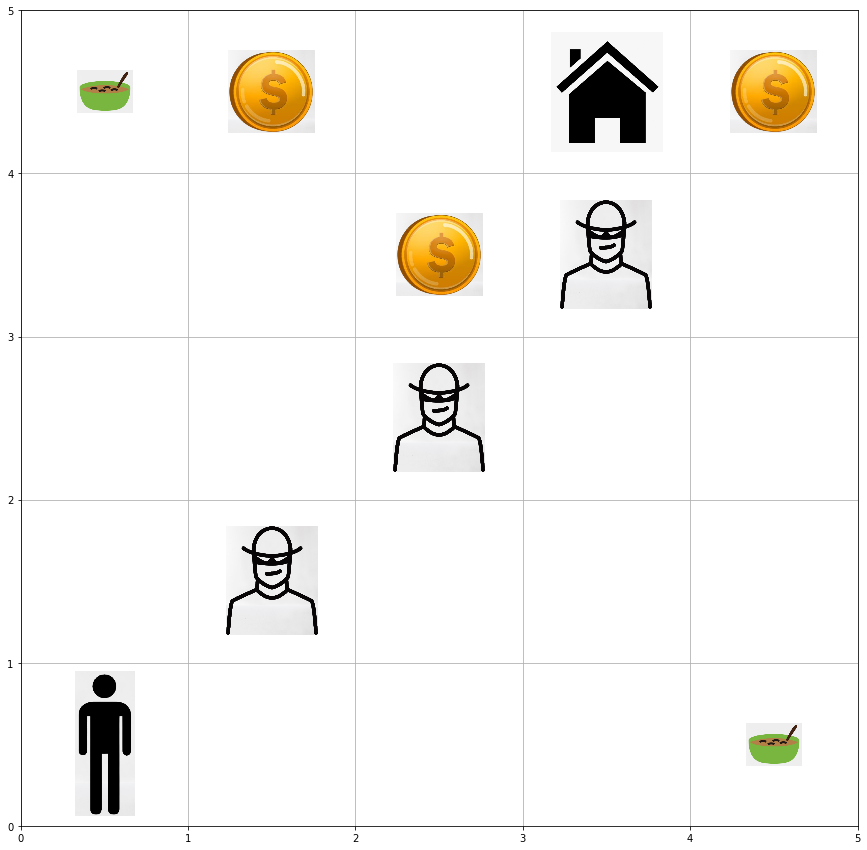

In [170]:
# env = CityTravels(env_type = "stochastic")
env = CityTravels("deterministic",10)
env.reset()
env.render()

action : 2
reward : -0.1
Total reward : -0.1
Timesteps : 1
-------------------------------------
action : 2
reward : -0.1
Total reward : -0.2
Timesteps : 2
-------------------------------------
action : 1
reward : -0.1
Total reward : -0.30000000000000004
Timesteps : 3
-------------------------------------
action : 1
reward : -20
Total reward : -20.3
Timesteps : 4
-------------------------------------
action : 2
reward : 10
Total reward : -10.3
Timesteps : 5
-------------------------------------
action : 3
reward : -0.1
Total reward : -10.4
Timesteps : 6
-------------------------------------
action : 2
reward : -0.1
Total reward : -10.5
Timesteps : 7
-------------------------------------
action : 3
reward : -0.1
Total reward : -10.6
Timesteps : 8
-------------------------------------
action : 1
reward : -0.1
Total reward : -10.7
Timesteps : 9
-------------------------------------
action : 2
reward : -20
Total reward : -30.7
Timesteps : 10
-------------------------------------


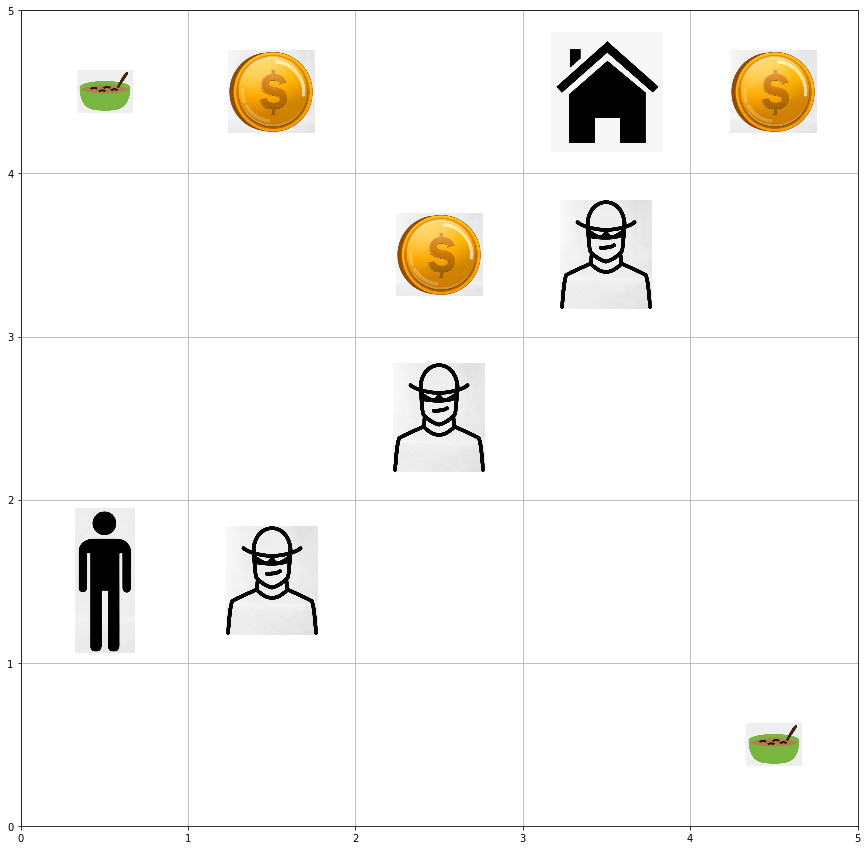

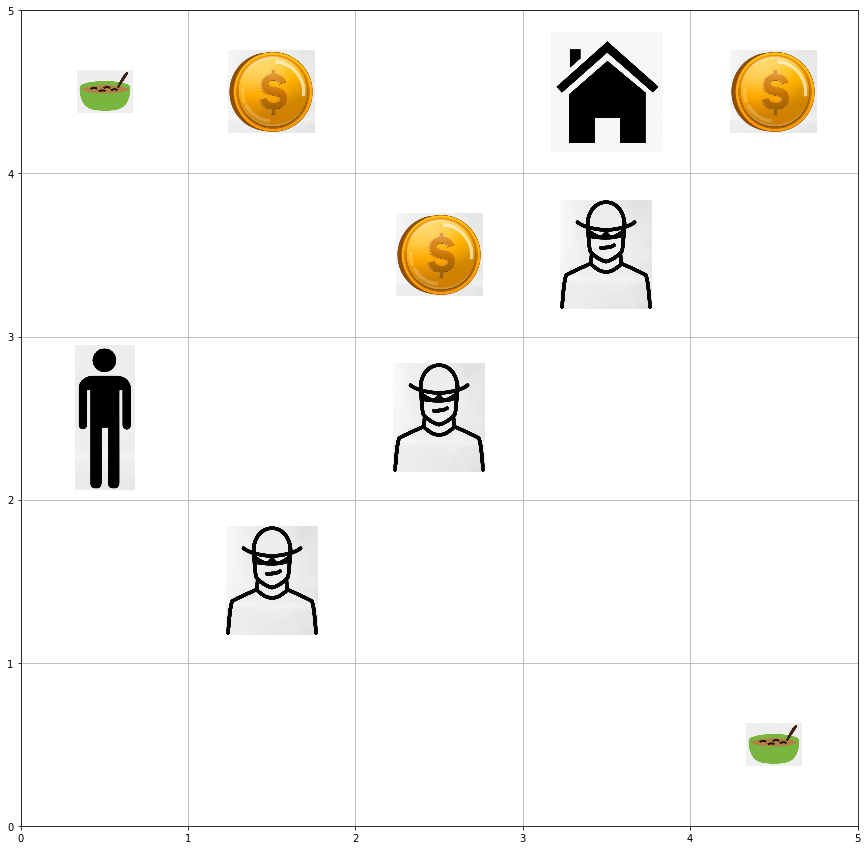

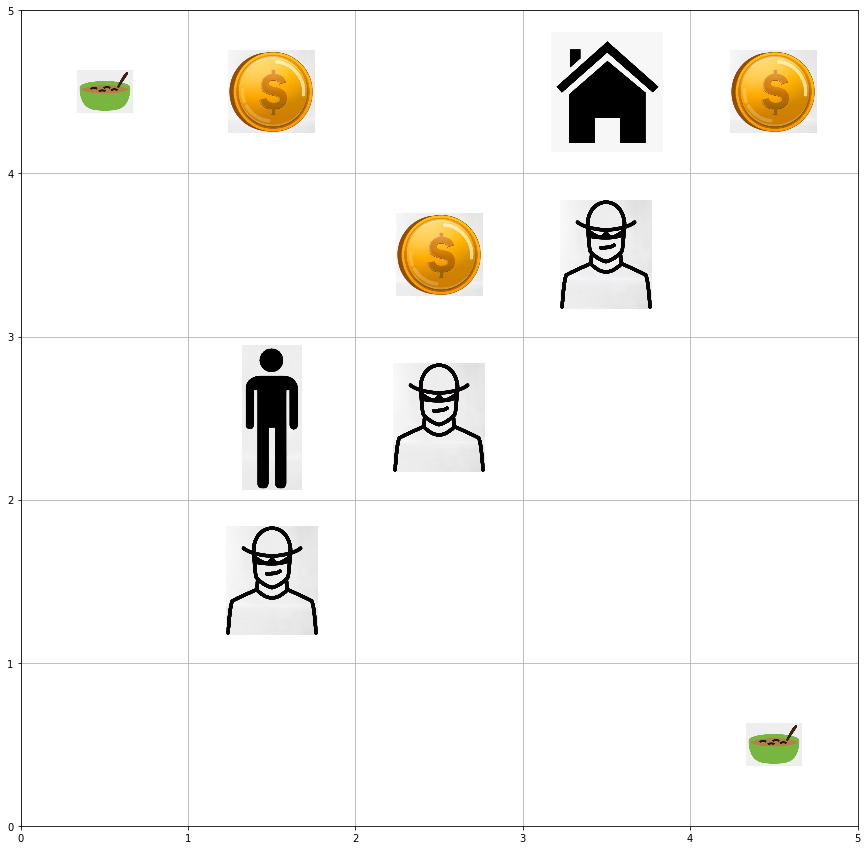

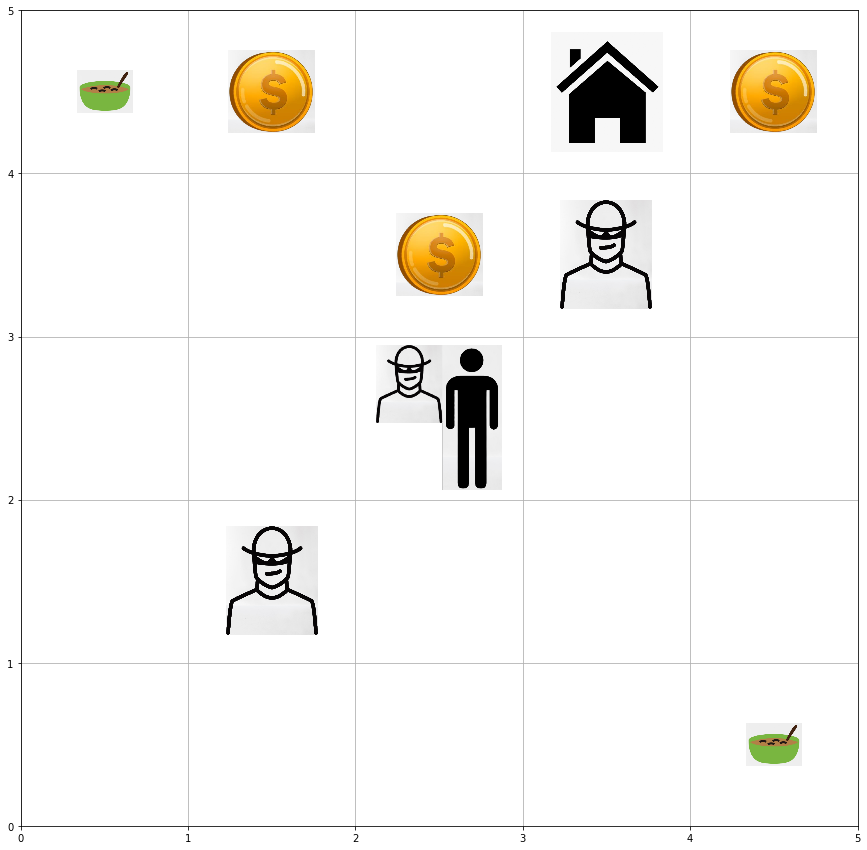

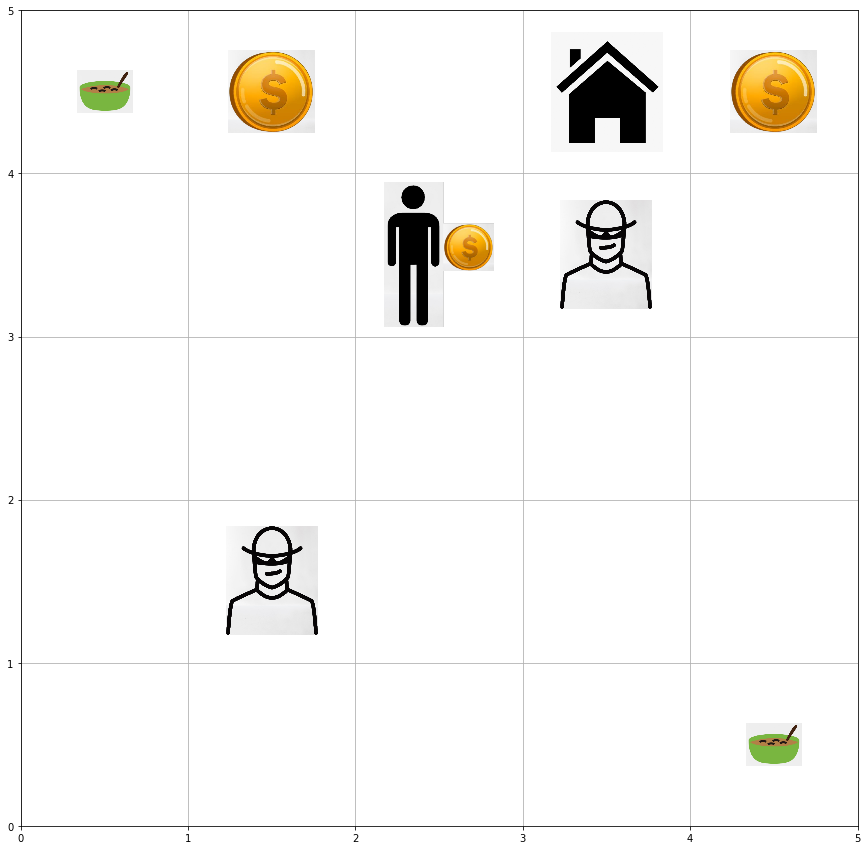

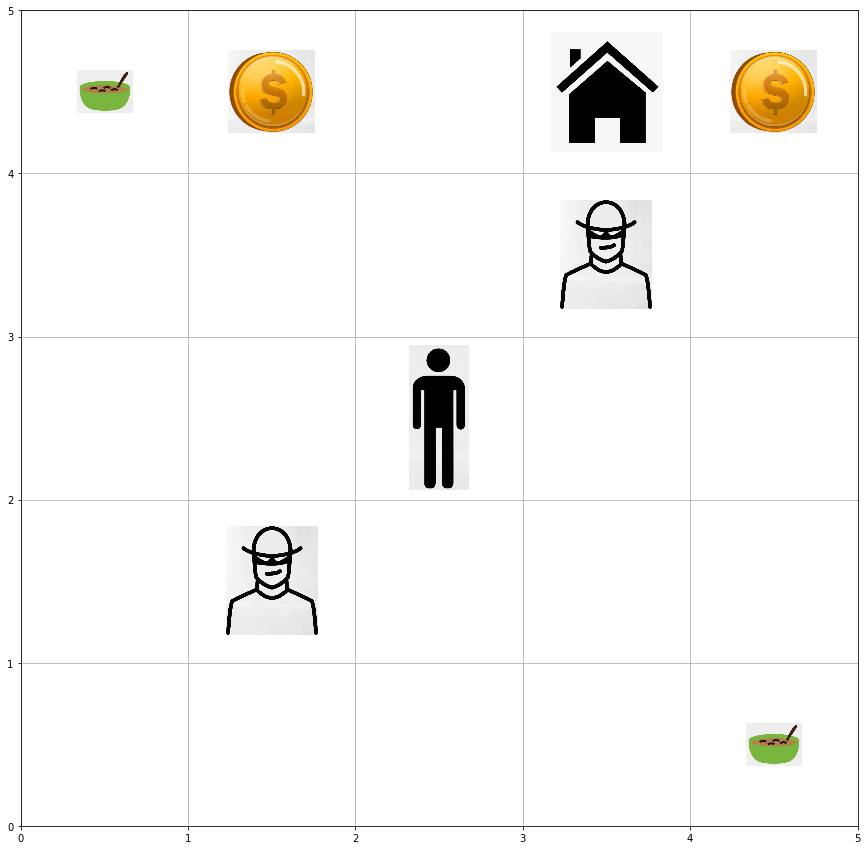

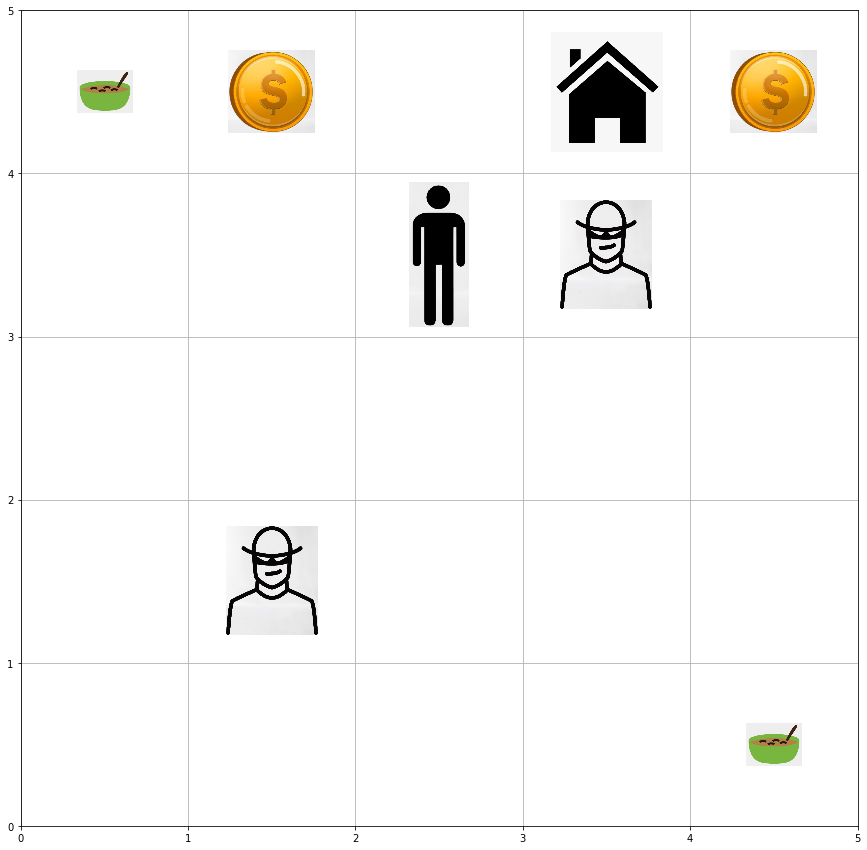

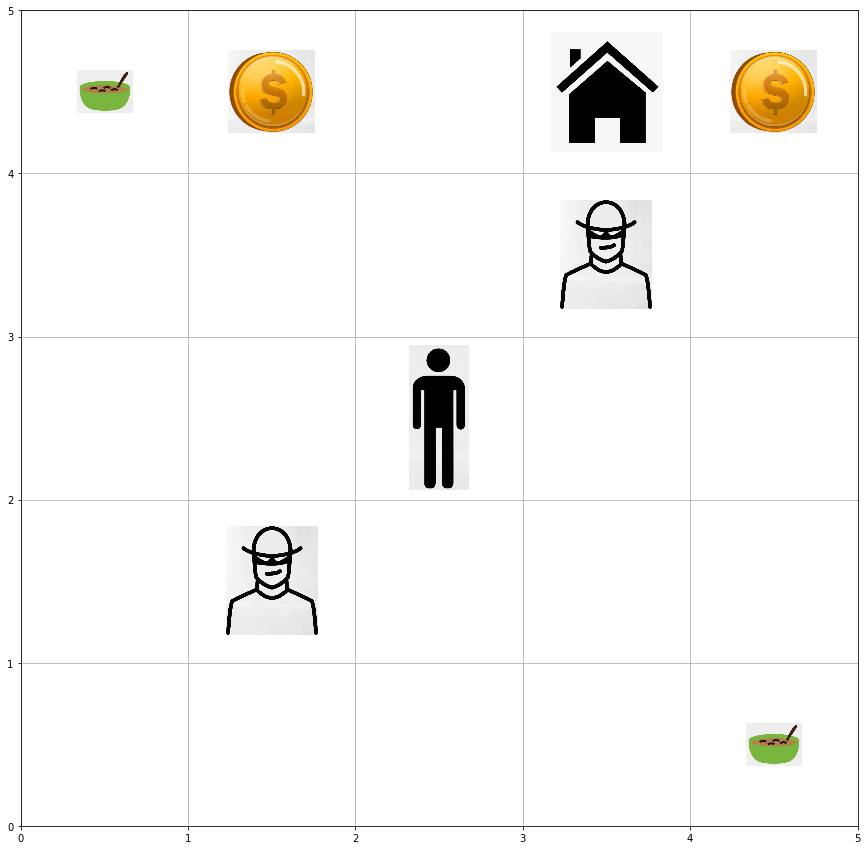

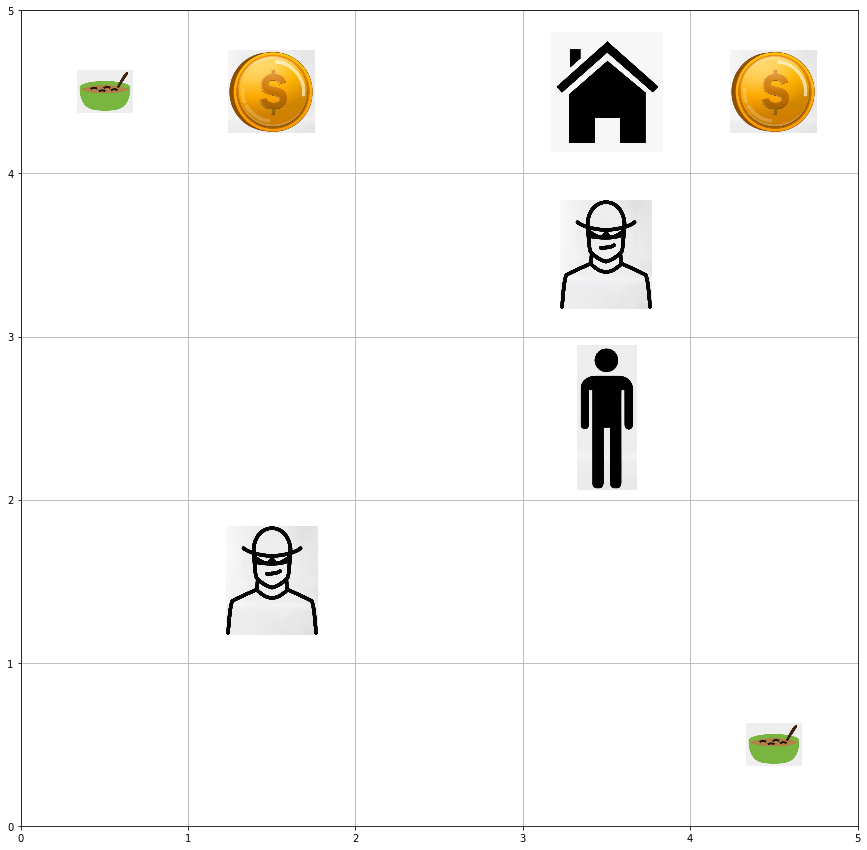

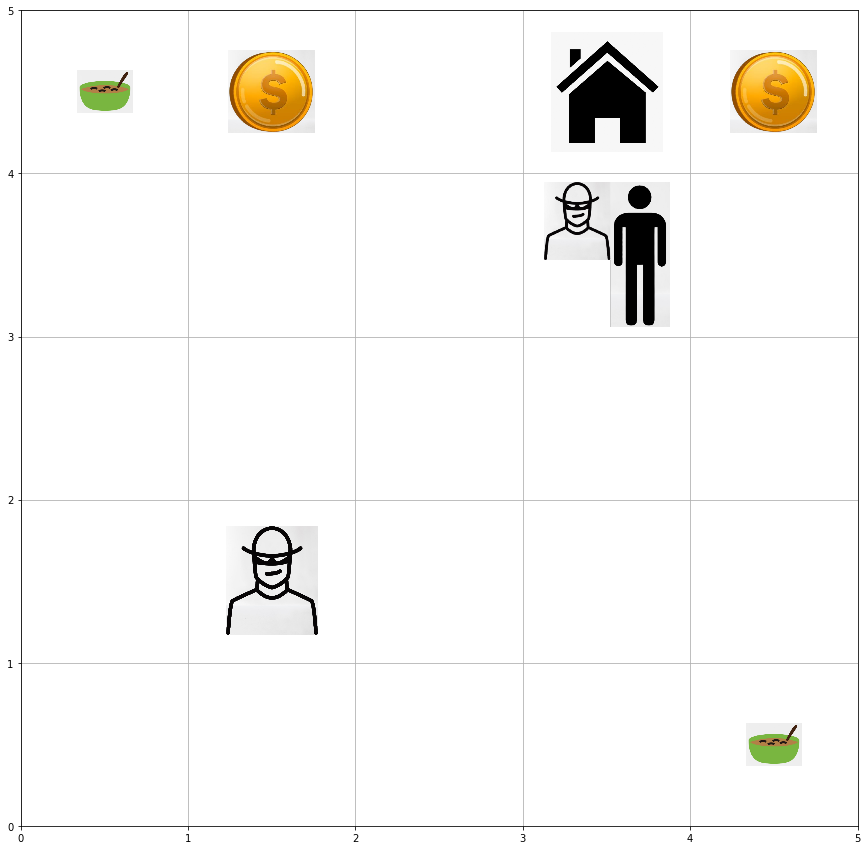

In [171]:
# Running agent for 10 timesteps

done = False
while not done:
    action = random.randint(0,3)
    print("action : {}".format(action))
    observation, reward, done, _ = env.step(action)
    env.render(reward)
    print("reward : {}".format(reward))
    print("Total reward : {}".format(env.total_reward))
    print("Timesteps : {}".format(env.timestep))
    print("-------------------------------------")



In [369]:
class Q_learning():
    def __init__(self):
        self.q_table = np.zeros((grid_size[0]*grid_size[1],len(action_space)))
    
    def update_table(self,state,action,env,reward):
        new_state = env.agent_pos[1]*grid_size[1] + env.agent_pos[0]
        self.q_table[state,action] = self.q_table[state,action] + hyper_parameters['learning_rate']*(reward + hyper_parameters['discount_factor']*np.max(self.q_table[new_state,:]) - self.q_table[state,action])
        
    def train(self,env_type):
        env = CityTravels(env_type,hyper_parameters['max_timesteps'])
        metrics['timesteps'], metrics['penalties'], metrics['rewards'], metrics['total_rewards'], metrics['epsilon_decay'] = [], [], [], [], []
        epochs = 0
        for i in range(number_of_episodes):
            env.reset()
            if i%100 == 0:
#                 print(i)
                hyper_parameters['learning_rate'] /= 10
#                 hyper_parameters['discount_factor'] /= 2.0


            done = False
            while not done:
                state = env.agent_pos[1]*grid_size[1] + env.agent_pos[0]
                if random.random() < hyper_parameters['epsilon']:
                    action = random.randint(0,3)
                else:
                    action = np.argmax(self.q_table[state,:])
                    
                observation, reward, done, _ = env.step(action)
                self.update_table(state,action,env,reward) 
            
            
            metrics['timesteps'].append(env.timestep)
            metrics['penalties'].append(env.penalties)
            metrics['rewards'].append(env.rewards)
            metrics['total_rewards'].append(env.total_reward)
            metrics['epsilon_decay'].append(hyper_parameters['epsilon'])
            hyper_parameters['epsilon'] /= hyper_parameters['epsilon_decay']
            
    
    def execute(self,env_type):
        env = CityTravels(env_type, hyper_parameters['max_timesteps'])
        env.reset()
        env.render()
        metrics['rewards_evaluation'] = [0]
        done = False
        while not done:
            state = env.agent_pos[1]*grid_size[1] + env.agent_pos[0]
            action = np.argmax(self.q_table[state,:])
            print("pos : {} state : {} action : {}".format(env.agent_pos, state,action))
            observation, reward, done, _ = env.step(action)
            env.render(reward)
            print(env.total_reward)
            metrics['rewards_evaluation'].append(env.total_reward)
        

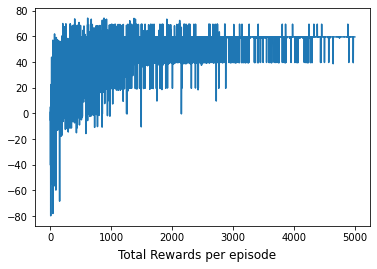

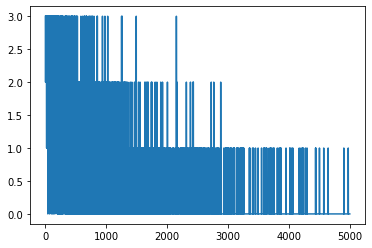

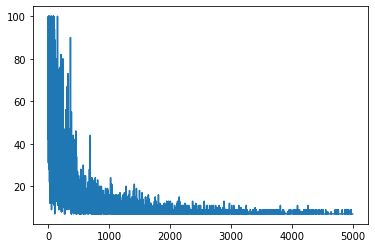

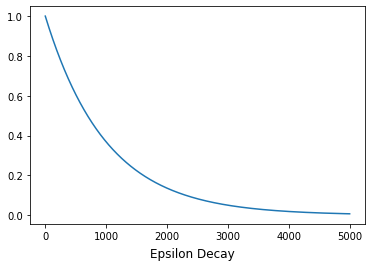

In [440]:
# Q-learning deterministic
hyper_parameters = {}
hyper_parameters['learning_rate'] = 0.9
hyper_parameters['max_timesteps'] = 100
hyper_parameters['epsilon'] = 1
hyper_parameters['epsilon_decay'] = 1.001
hyper_parameters['discount_factor'] = 0.999
number_of_episodes = 5000
metrics = {}
k_det = Q_learning()
k_det.train("deterministic")
plt.plot(metrics['total_rewards'])
plt.figtext(0.5, 0.01, "Total Rewards per episode", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()
plt.plot(metrics['penalties'])
plt.show()
plt.plot(metrics['timesteps'])
plt.show()
plt.plot(metrics['epsilon_decay'])
plt.figtext(0.5, 0.01, "Epsilon Decay", wrap=True, horizontalalignment='center', fontsize=12)


plt.show()
# k_det.execute("deterministic")
metrics_q_det = copy.deepcopy(metrics)

64.6

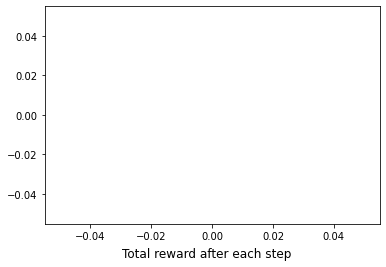

In [285]:
metrics_q_det['rewards_evaluation'] = metrics_q_det['rewards_evaluation'][2:]
metrics_q_det['rewards_evaluation'].insert(0,0)
plt.plot(metrics_q_det['rewards_evaluation'])
plt.figtext(0.5, 0.01, "Total reward after each step", wrap=True, horizontalalignment='center', fontsize=12)

min(metrics_q_det['total_rewards'][66:]) # Took 66 steps to reach optimal policy

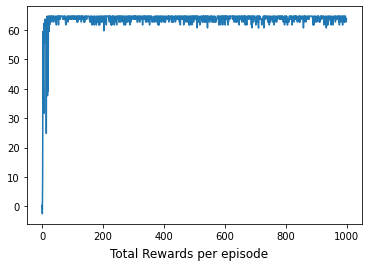

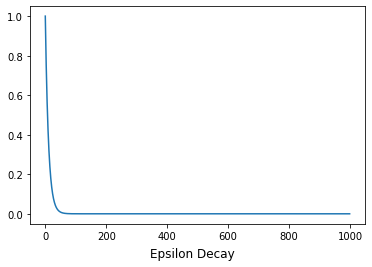

pos : [0 0] state : 0 action : 2
-0.1
pos : [0 1] state : 5 action : 2
-0.2
pos : [0 2] state : 10 action : 2
-0.30000000000000004
pos : [0 3] state : 15 action : 2
4.7
pos : [0 4] state : 20 action : 1
14.7
pos : [1 4] state : 21 action : 1
14.6
pos : [2 4] state : 22 action : 1
64.6


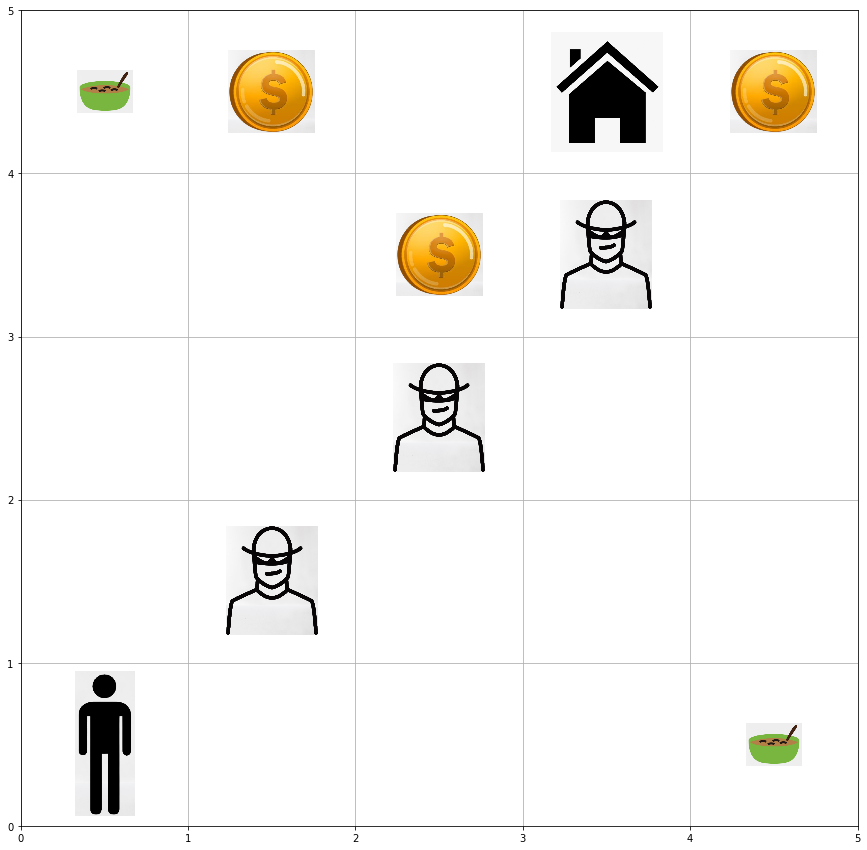

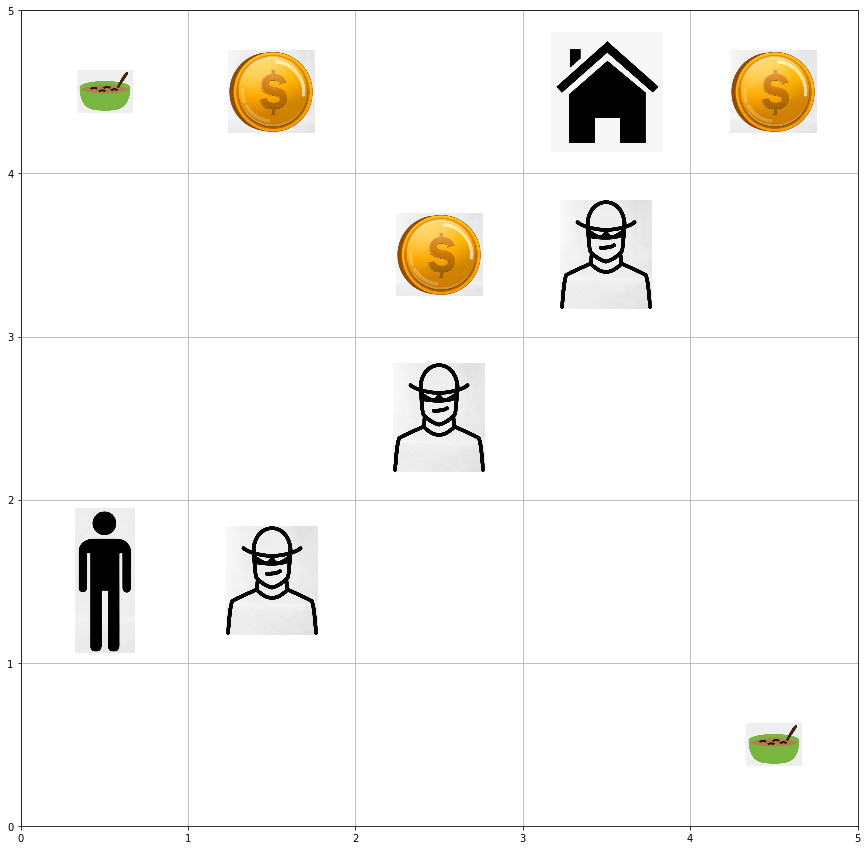

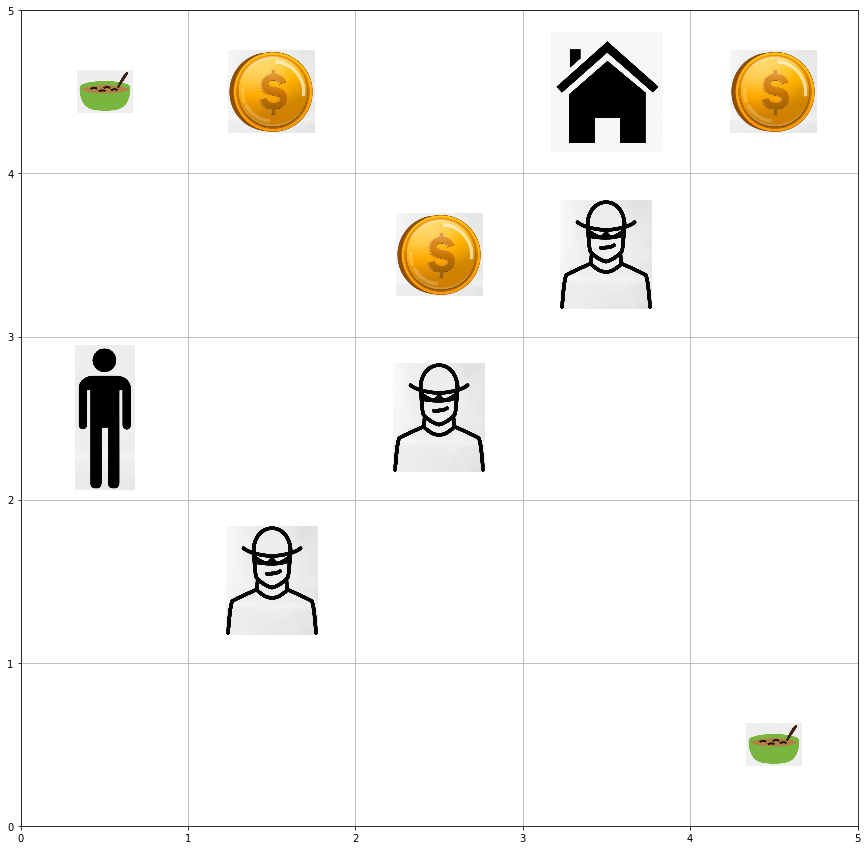

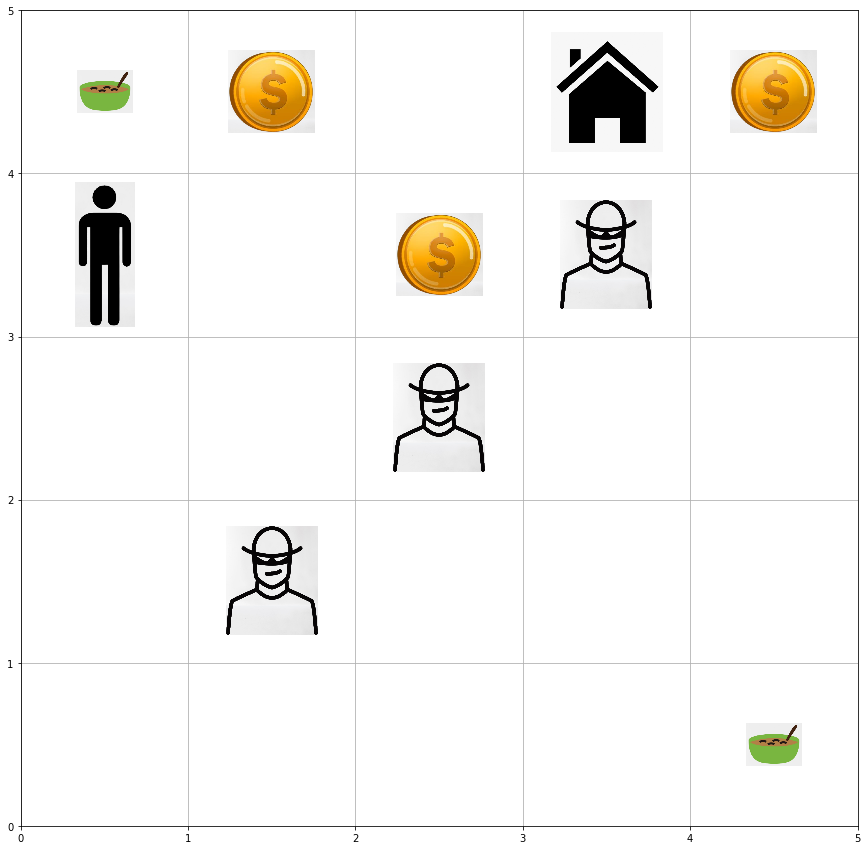

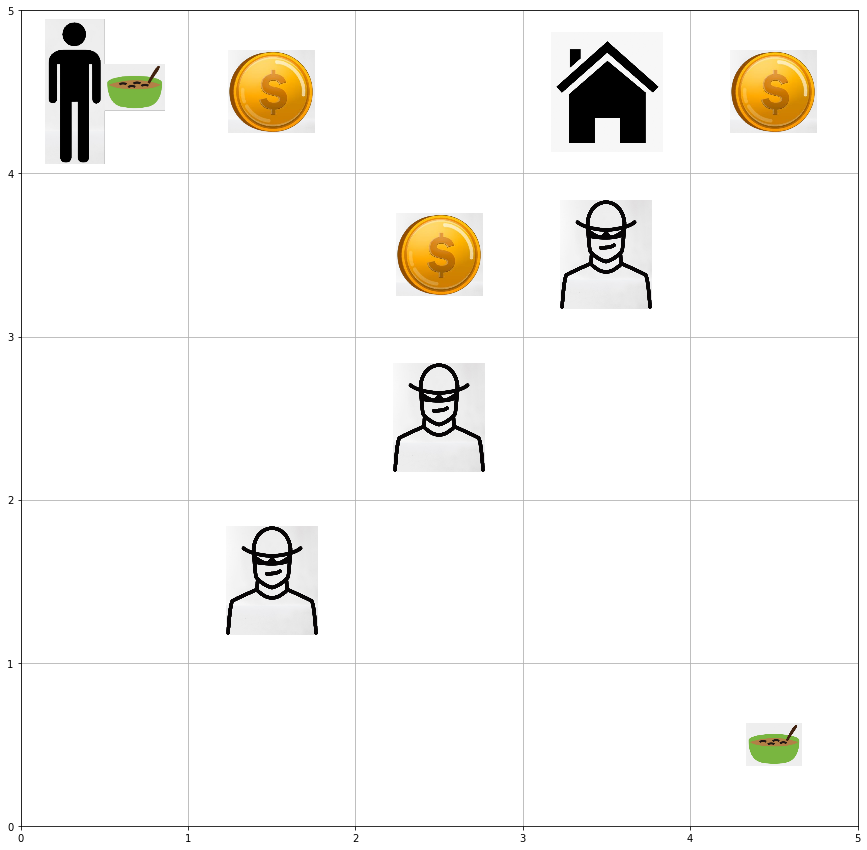

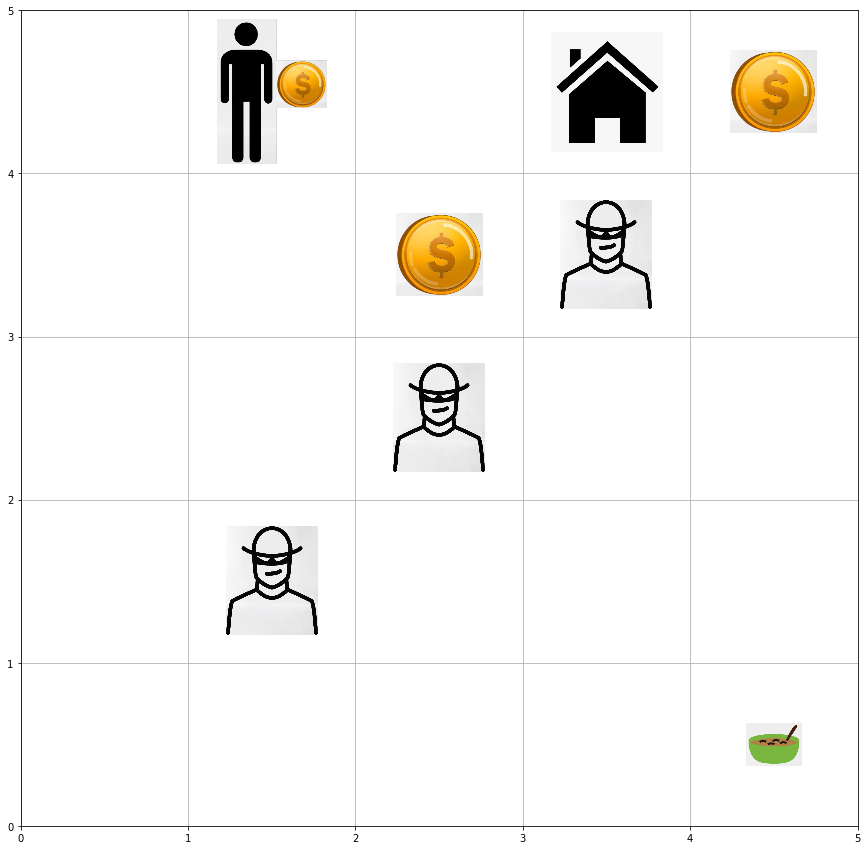

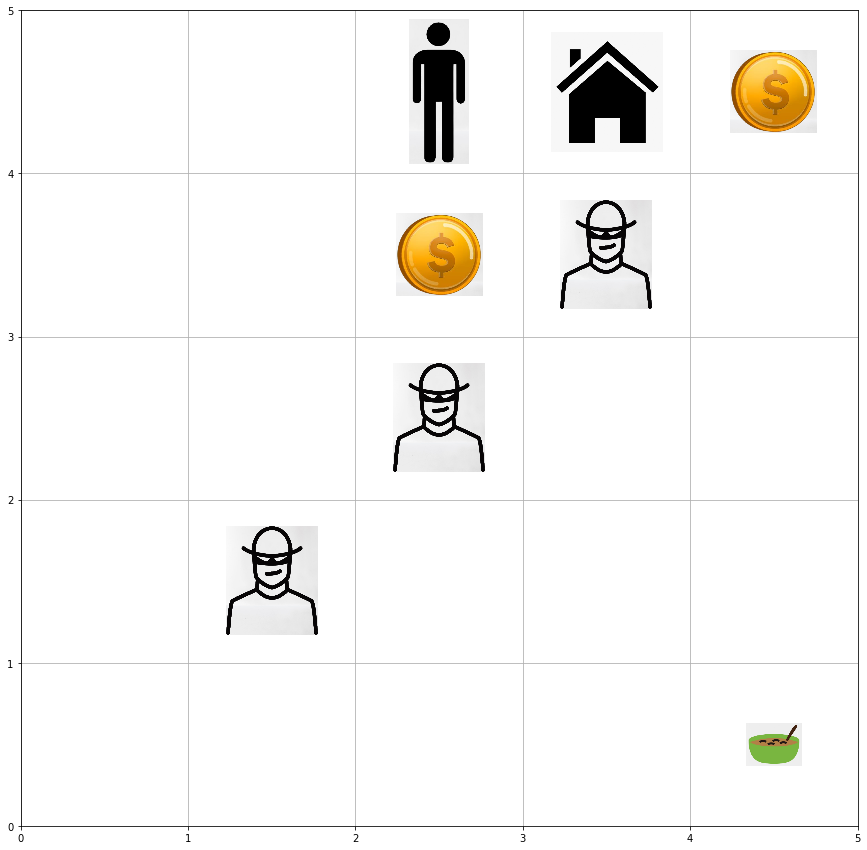

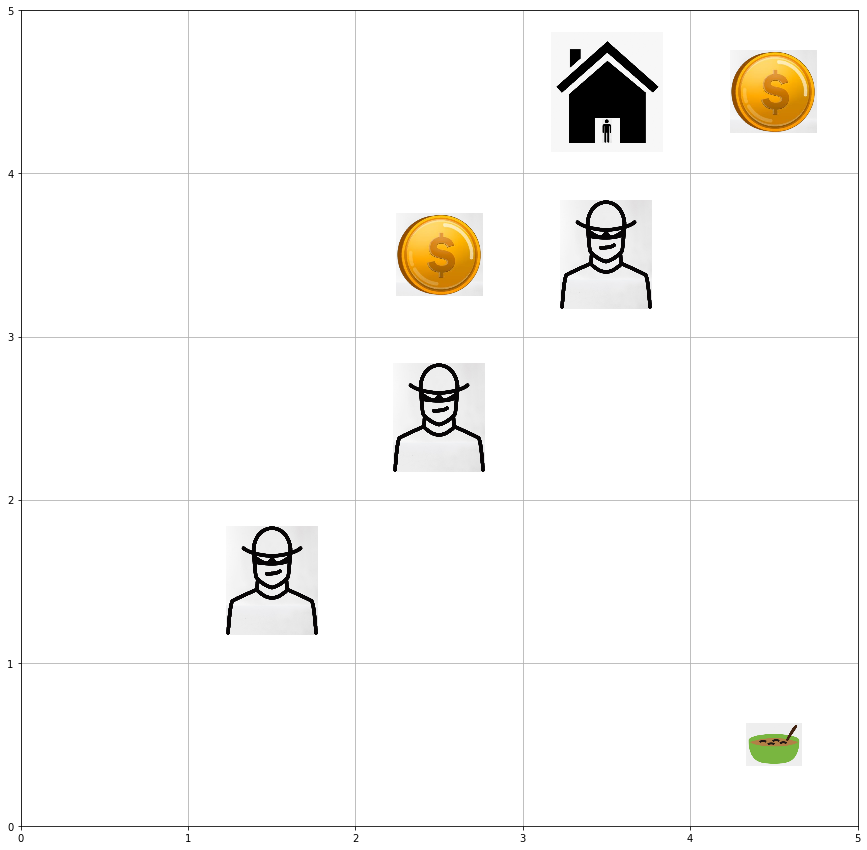

In [371]:
# Q-learning stochastic
hyper_parameters = {}
hyper_parameters['learning_rate'] = 0.9
hyper_parameters['max_timesteps'] = 150
hyper_parameters['epsilon'] = 1
hyper_parameters['discount_factor'] = 0.99
hyper_parameters['epsilon_decay'] = 1.1
number_of_episodes = 1000
metrics = {}
k_sto = Q_learning()
k_sto.train("stochastic")
metrics_q_sto = copy.deepcopy(metrics)
plt.plot(metrics['total_rewards'])
plt.figtext(0.5, 0.01, "Total Rewards per episode", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()
# plt.plot(metrics['penalties'])
# plt.show()
# plt.plot(metrics['timesteps'])
# plt.show()
plt.plot(metrics['epsilon_decay'])
plt.figtext(0.5, 0.01, "Epsilon Decay", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()
k_sto.execute("stochastic")
metrics_q_sto = copy.deepcopy(metrics)

[0, -0.1, -0.2, -0.30000000000000004, 4.7, 14.7, 14.6, 64.6]


60.6

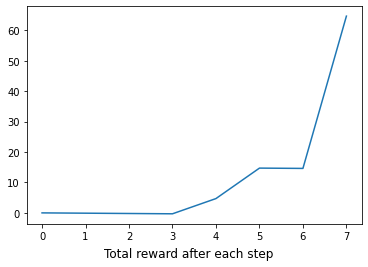

In [422]:
plt.plot(metrics_q_sto['rewards_evaluation'])
plt.figtext(0.5, 0.01, "Total reward after each step", wrap=True, horizontalalignment='center', fontsize=12)
print(metrics_q_sto['rewards_evaluation'])
